<a href="https://colab.research.google.com/github/BongekileCS/BdayCard/blob/main/Perfect_model_AI_DeTECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set your dataset directory (replace with your specific path)
data_dir = '/content/drive/My Drive/dataset/images'


Mounted at /content/drive


In [3]:
keyword=["Normal","Tuberculosis"]
class_folders = os.listdir(data_dir)
image_paths = []
labels = []

for class_folder in class_folders:
    for key in keyword:
        if key in class_folder:
            class_path = os.path.join(data_dir, class_folder)
            image_files = os.listdir(class_path)
            for image_file in image_files:
                image_path = os.path.join(class_path, image_file)
                image_paths.append(image_path)
                labels.append(class_folder)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})

In [4]:
print("The classes:\n", np.unique(df['label']))

The classes:
 ['Normal' 'Tuberculosis']


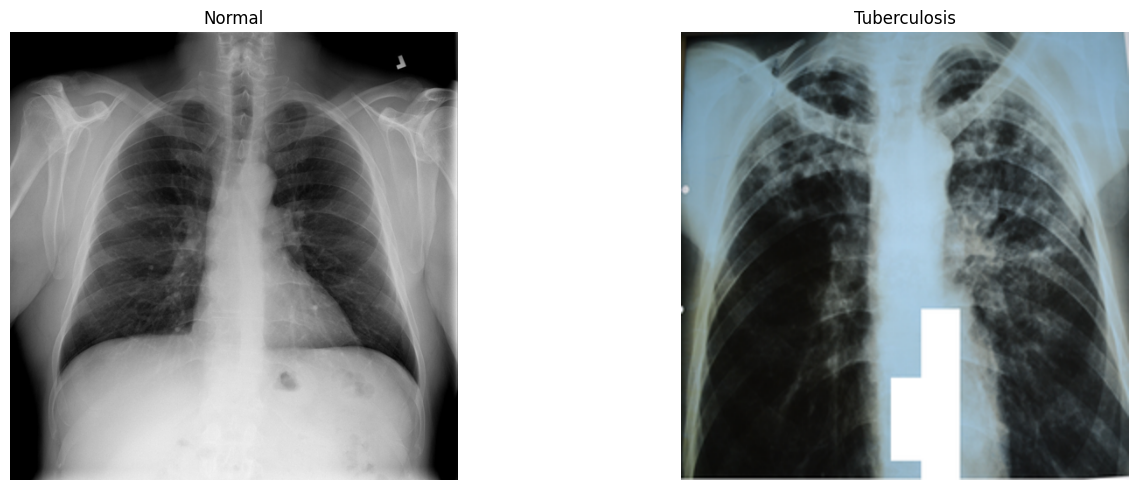

In [20]:
num_classes = len(df['label'].unique())

num_images_per_row = 2
num_rows = (num_classes + num_images_per_row - 1) // num_images_per_row

plt.figure(figsize=(15, 5 * num_rows))

for i, plant_class in enumerate(df['label'].unique()):
    plt.subplot(num_rows, num_images_per_row, i + 1)
    path = os.path.join(data_dir, df[df['label'] == plant_class]['image_path'].iloc[0])

    if os.path.exists(path):
        sample_image = cv2.imread(path)
        if sample_image is not None:
            plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
            plt.title(plant_class)
            plt.axis('off')

        else:
            print(f"Error: Unable to load image from path: {path}")


plt.tight_layout()
plt.show()

In [21]:
from sklearn.model_selection import train_test_split
train_df, rest_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(rest_df, test_size=0.5, random_state=42)

In [22]:
def load_images_for_cnn(train_df, val_df, test_df, batch_size=32, target_size=(224, 224)):

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    train_generator = train_datagen.flow_from_dataframe(
 train_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    validation_generator = validation_datagen.flow_from_dataframe(
        val_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [23]:
train_generator, validation_generator, test_generator = load_images_for_cnn(train_df, val_df, test_df, batch_size=32, target_size=(224, 224))

Found 2553 validated image filenames belonging to 2 classes.
Found 319 validated image filenames belonging to 2 classes.
Found 320 validated image filenames belonging to 2 classes.


In [30]:
from tensorflow.keras.applications import  DenseNet169
base_model = DenseNet169(weights='imagenet', include_top = False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model_1 = Model(inputs=base_model.input, outputs=predictions)

learning_rate = 0.00001

n = 5
base_model.trainable = True
for layer in base_model.layers[:-n]:
    layer.trainable = False

model_1.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 10
history_1 = model_1.fit(train_generator, epochs=epochs, validation_data=validation_generator)
test_loss, test_accuracy = model_1.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 2184s 25s/step - accuracy: 0.8589 - loss: 0.4073 - val_accuracy: 0.9091 - val_loss: 0.2656
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 71s 830ms/step - accuracy: 0.9246 - loss: 0.2068 - val_accuracy: 0.9091 - val_loss: 0.1867
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 82s 827ms/step - accuracy: 0.9455 - loss: 0.1517 - val_accuracy: 0.9310 - val_loss: 0.1387
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 80s 800ms/step - accuracy: 0.9668 - loss: 0.1062 - val_accuracy: 0.9624 - val_loss: 0.1052
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 73s 831ms/step - accuracy: 0.9741 - loss: 0.0929 - val_accuracy: 0.9781 - val_loss: 0.0850
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 81s 839ms/step - accuracy: 0.9763 - loss: 0.0854 - val_accuracy: 0.9843 - val_loss: 0.0744
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 79s 810ms/step - accuracy: 0.9746 - loss: 0.0823 - val_accuracy: 0.9749 - val_loss: 0.0734
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 81s 793ms/step - accuracy: 0.9796 - loss: 0.0713 - val_accuracy: 0.974

In [31]:
import numpy as np
from sklearn import metrics
predictions = model_1.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = ['Normal','Tuberculosis']
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 431ms/step
              precision    recall  f1-score   support

      Normal       0.96      1.00      0.98       284
Tuberculosis       1.00      0.69      0.82        36

    accuracy                           0.97       320
   macro avg       0.98      0.85      0.90       320
weighted avg       0.97      0.97      0.96       320



In [32]:
test_predictions = model_1.predict(test_generator)
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 467ms/step


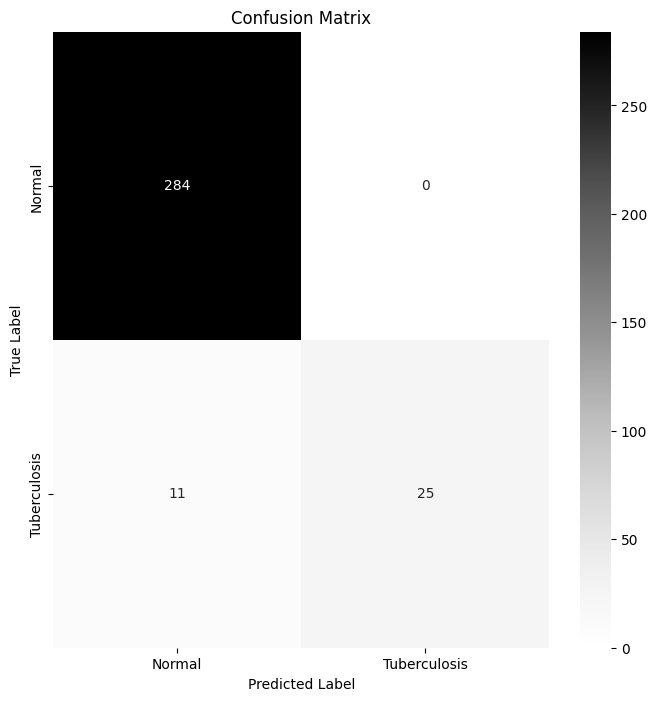

In [33]:
plt.figure(figsize=(8, 8))
conf_matrix = confusion_matrix(test_true_labels, test_predicted_labels)
class_names = [label for label in np.unique(df['label'])]
seaborn.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greys', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()





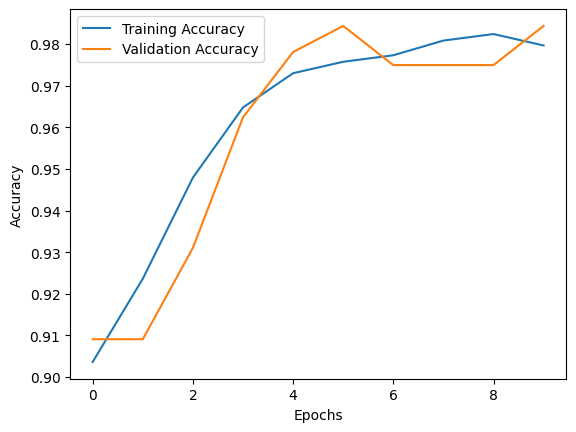

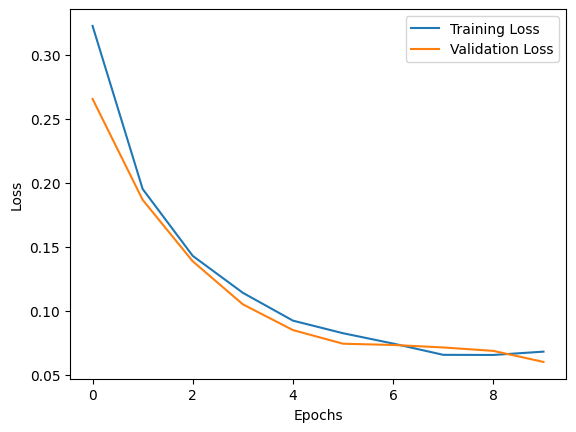

In [34]:
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



